Final Tutorial

In [ ]:
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
import spotipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Use xml files to scrape from spotify charts
for each track show their streams per day, maybe as an array or another dataframe
from there spotipy api can be used to observe the details of these songs

In [ ]:
# Collect links from spotify charts top 200 streams per day
ref_str = "https://spotifycharts.com/regional/global/daily/"
ref_arr = []

# gets every day from janurary 2017 to October 2020

# for year in range(2017, 2021):
for year in range(2017, 2018):
    date = ""
    
    endingMonth = 12
    if year == 2020:
        endingMonth = 10
        
    # for month in range (1, endingMonth + 1):
    for month in range (1,2):
       
        dayCount = -1

        #gets proper day count per month
        thirtyDayCountMonths = [4, 6, 9, 11]
        if month == 2:
            dayCount = 29
        elif month in thirtyDayCountMonths:
            dayCount = 30
        else:
            dayCount = 31

        if int(month) < 10:
            month = "0" + str(month)
        for day in range (1, 16):
           
            if int(day) < 10:
                day = "0" + str(day)

            date = str(year) + "-" + str(month) + "-" + str(day) + "/download"
            date = ref_str + date
            ref_arr.append(date)

ref_arr

In [ ]:
#Loop downloading and appending of dataframes 

df = pd.DataFrame(columns =['position', 'track_name', 'artist', 'streams', 'url', 'date'] )
#make dir to save to
path = "sheets"
try:
    os.mkdir(path)
except OSError:
    print ("Folder already exists")

for i in ref_arr:
    r = requests.get(i, allow_redirects = True)
    #String manipulation to read from the correct csv files
    date = i[48:58]
    #print(date)
    fileName = "regional-global-daily-" + date + ".csv"
    #print(fileName)
    open(fileName, "wb").write(r.content)

    #os.rename(fileName, "sheets/" + fileName)

    df_new = pd.read_csv(fileName)
    df_new.columns= ['position', 'track_name', 'artist', 'streams', 'url']
    df_new['date'] = date
    
    df_new = df_new.iloc[1:] #deletes junk row from csv conversion
    df = df.append(df_new)



df.drop(['position'], axis=1, inplace=True) #delete position row since rank alraedy has this information

In [ ]:
df

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials


SPOTIPY_CLIENT_ID="ea1a162fbc6f413990542b76ab82a168"
SPOTIPY_CLIENT_SECRET="a09882042ce54f158fdd2b6baaf2b26d"
SPOTIPY_CLIENT_REDIRECT="http://www.cs.umd.edu/class/fall2020/cmsc320-0201/"

scope = "user-library-read"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope, client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET, redirect_uri=SPOTIPY_CLIENT_REDIRECT))

results = sp.current_user_saved_tracks()


# How to get audio features of a track from our data frame
#not needed anymore but good refrence for how to get trackdata
#trackName = df.iloc[0].at['track_name']
#trackNameWithoutSpaces = '+'.join(trackName.split())
#print(trackNameWithoutSpaces)
#trackItem = sp.search(trackNameWithoutSpaces, 1, 0)
#track_id = trackItem['tracks']['items'][0]['id']
#audiofeatures = sp.audio_features(track_id)
#print(track_id)
#audiofeatures[0]

In [ ]:
#gets artist genres and artist ids for each artist in dataframe and puts them in arrays
artist_genres = []
artist_ids = []

for index, row in df.iterrows():
    artist = row['artist']
    #print(index)
    #print(artist)
    trackArtistWithoutSpaces = '+'.join(artist.split())
    result = sp.search(trackArtistWithoutSpaces)
    track = result['tracks']['items'][0]
    artist_id = track["artists"][0]["id"]
    #print(artist_id)
    #print(track)
    artist_ids.append(artist_id)
    artist = sp.artist(track["artists"][0]["external_urls"]["spotify"])
    artist_genres.append(artist["genres"])
    #print(artist["genres"])



In [ ]:
#add artist id and genres to dataframe
df['Artist Id'] = artist_ids
df['artist_genres'] = artist_genres

In [ ]:
#print(df["artist_genres"])

#creates new column in dataframe based on genre filter within filter func
def filt_func(genre_list):
    genre = ['pop','rap','edm','rock','indie']
    result = list(filter(lambda x: x in genre, genre_list))
    return "other" if len(result) == 0 else result[0]
    #print(result)
df['genre'] = df['artist_genres'].apply(lambda x: filt_func(x))
df['streams'] = df['streams'].apply(lambda x: int(x))

In [ ]:
audioFeaturesDf = pd.DataFrame(columns=["duration_ms", "key", "mode", "time_signature", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", "tempo", "id", "uri", "track_href", "analysis_url", "type"])
#for index, row in df.iterrows():
trackName = df.iloc[0].at['track_name']
trackNameWithoutSpaces = '+'.join(trackName.split())
trackItem = sp.search(trackNameWithoutSpaces, 1, 0)
track_id = trackItem['tracks']['items'][0]['id']
audiofeatures = sp.audio_features(track_id)
print(track_id)
print(audiofeatures[0]['danceability'])
print(row['track_name'])
    

In [ ]:
trackName = df.iloc[0].at['track_name']
trackNameWithoutSpaces = '+'.join(trackName.split())
searchQuery = sp.search(trackNameWithoutSpaces, 1, 0)
track_object = searchQuery['tracks']['items'][0]
artist_object = track_object['artists'][0]
artist_id = artist_object['id']
track_id = track_object['id']
audiofeatures = sp.audio_features(track_id)
print(track_id)
print(artist_id)
print(audiofeatures[0]['danceability'])
print(trackNameWithoutSpaces)

In [ ]:
artist_id_list = []
track_id_list = []
audioFeaturesDf = pd.DataFrame()
# This gets the artist id and the track id (which is included in the "audio_features" search we make)
# Does this by making one search through the api and gets the ids from the information returned
for index, row in df.iterrows():
    trackName = df.iloc[index - 1].at['track_name']
    trackNameWithoutSpaces = '+'.join(trackName.split())
    searchQuery = sp.search(trackNameWithoutSpaces, 1, 0)
    track_id = ""
    artist_id = ""
    if (len(searchQuery['tracks']['items']) != 0):
        track_object = searchQuery['tracks']['items'][0]
        artist_object = track_object['artists'][0] if type(track_object['artists']) is list else track_object['artists']
        artist_id = artist_object['id']
        track_id = track_object['id']
        artist_id_list.append(artist_id)
        track_id_list.append(track_id)
    #print(trackItem)
    else:
        # If our query returned nothing then append a nan in the place of artist and track for this entry
        artist_id_list.append(np.nan)
        track_id_list.append(np.nan)
    audiofeatures = {'duration_ms' : np.nan, 'key' : np.nan, 'mode' : np.nan, 'time_signature' : np.nan, 'acousticness' : np.nan, 'danceability' : np.nan, 'energy' : np.nan, 'instrumentalness' : np.nan, 'liveness' : np.nan, 'loudness' : np.nan, 'speechiness' : np.nan, 'valence' : np.nan, 'tempo' : np.nan, 'id' : np.nan, 'uri' : np.nan, 'track_href' : np.nan, 'analysis_url' : np.nan, 'type' : np.nan, }
    #print(audiofeatures)
    # If we successfully found a track when we did our seach, then get the audio features for that
    if (track_id != ""):
        audiofeatures = sp.audio_features(track_id)[0]
    #print(track_id)
    #print(audiofeatures)
    audioFeaturesDf = audioFeaturesDf.append(audiofeatures, ignore_index=True)
    
audioFeaturesDf

In [ ]:
audioFeaturesDf['artist_id'] = artist_id_list
audioFeaturesDf

In [ ]:
audioFeaturesDf
df['duration_ms'] = audioFeaturesDf['duration_ms']
df['acousticness'] = audioFeaturesDf['acousticness']
df['danceability'] = audioFeaturesDf['danceability']
df['energy'] = audioFeaturesDf['energy']
df['instrumentalness'] = audioFeaturesDf['instrumentalness']
df['liveness'] = audioFeaturesDf['liveness']
df['loudness'] = audioFeaturesDf['loudness']
df['speechiness'] = audioFeaturesDf['speechiness']
df['valence'] = audioFeaturesDf['valence']
df['tempo'] = audioFeaturesDf['tempo']
df

In [ ]:
#visualization
#plotting all the new metrics in our dataframe vs streams

In [ ]:
from scipy.stats import normaltest
from numpy.random import seed
from numpy.random import randn
alpha = 0.05
#data = df['tempo'].sample(n=10).array
data = []
for i in range(0,100):
    data.append(np.mean(df['streams'].sample(n=100)))
print(data)
plt.hist(data)
plt.xlabel("Estimate")
plt.ylabel("Frequency")

Text(0, 0.5, 'streams in millions')

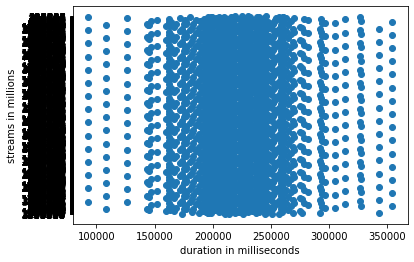

In [82]:
plt.scatter(df['duration_ms'],df['streams'])
plt.xlabel('duration in milliseconds')
plt.ylabel('streams in millions')

In [ ]:
plt.scatter(df['acousticness'],df['streams'])
plt.xlabel('accousticness scale of 0-1')
plt.ylabel('streams in millions')

In [ ]:
plt.scatter(df['danceability'],df['streams'])
plt.xlabel('danceability scale of 0-1')
plt.ylabel('streams in millions')

In [ ]:
plt.scatter(df['energy'],df['streams'])
plt.xlabel('energy scale of 0-1')
plt.ylabel('streams in millions')

In [ ]:
plt.scatter(df['instrumentalness'],df['streams'])
plt.xlabel('instrumentalness scale of 0-1')
plt.ylabel('streams in millions')

In [ ]:
plt.scatter(df['liveness'],df['streams'])
plt.xlabel('liveness scale of 0-1')
plt.ylabel('streams in millions')

In [ ]:
plt.scatter(df['loudness'],df['streams'])
plt.xlabel('loudness SCALE???????????????????')
plt.ylabel('streams in millions')

In [ ]:
plt.scatter(df['speechiness'],df['streams'])
plt.xlabel('speechiness scale of 0-.5')
plt.ylabel('streams in millions')

In [ ]:
plt.scatter(df['valence'],df['streams'])
plt.xlabel('valence scale of 0-1')
plt.ylabel('streams in millions')

In [ ]:
plt.scatter(df['tempo'],df['streams'])
plt.xlabel('tempo scale of 0-200')
plt.ylabel('streams in millions')

In [ ]:
#violin plot of genre vs streams in millions
ax = sns.violinplot(x='genre', y='streams', data=df, palette='muted')


In [ ]:
plt.scatter(df['date'],df['streams'])
plt.xlabel('date')
plt.ylabel('streams in millions')

Can we find any trends within these features for the first 10 songs on our dataframe (a.k.a. the top 10 songs on the first of January)?

In [ ]:
sliceOfData = df.head(10)